# Práctica: detección de fraude mediante métodos de ensembles

ESTUDIANTES: 
- Renzo Carrasco Calle
- Anthony Guamán Mendoza

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/fraud.jpg" style="width:600px;">

En esta práctica vamos a utilizar todos los conocimientos adquiridos en los ejercicios anteriores, con el objetivo de construir un detector automático de fraude en pagos con tarjeta.

## Instrucciones

A lo largo del notebook encontrarás celdas que debes rellenar con tu propio código. Sigue las instrucciones del notebook y presta atención a los siguientes iconos:

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
Deberás resolver el ejercicio escribiendo tu propio código o respuesta en la celda inmediatamente inferior.
    <b>La nota máxima que puede obtenerse con esta clase de ejercicios es de 7 sobre 10.</b>
</font>

***

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/exclamation.png" height="80" width="80" style="float: right;"/>

***
<font color=#2655ad>
Esto es una pista u observación de utilidad que puede ayudarte a resolver el ejercicio. Presta atención a estas pistas para comprender el ejercicio en mayor profundidad.
</font>

***

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/pro.png" height="80" width="80" style="float: right;"/>

***
<font color=#259b4c>
Este es un ejercicio avanzado que te puede ayudar a profundizar en el tema, y a conseguir una calificación más alta. <b>Resolviendo esta clase de ejercicios puedes llegar conseguir hasta 3 puntos sobre 10.</b> ¡Buena suerte!</font>

***

Para evitar problemas con imports o incompatibilidades se recomienda ejecutar este notebook en uno de los [entornos de Ensembles recomendados](https://github.com/albarji/teaching-environments-ensembles).

El siguiente código mostrará todas las gráficas en el propio notebook en lugar de generar una nueva ventana.

In [13]:
#!pip install xgboost

In [14]:
#!pip install catboost

In [15]:
#!pip install lightgbm

In [16]:
import datetime
import matplotlib.pyplot as plt
from plotnine import *
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, BaggingClassifier,StackingClassifier, VotingClassifier, IsolationForest
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_curve, auc, confusion_matrix, average_precision_score, PrecisionRecallDisplay, precision_recall_curve
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression  
%matplotlib inline

## Carga y preparación de datos

Para este problema usaremos una versión reducida de los datos disponibles en la competición de Kaggle [IEEE-CIS Fraud Detection](https://www.kaggle.com/c/ieee-fraud-detection/data). Los datos a emplear están incluidos en la carpeta *data*, con ficheros separados para entrenamiento y test. Cada fichero incluye una gran cantidad de variables explicativas sobre la naturaleza de la operación con tarjeta realizada: puede encontrarse información sobre la naturaleza de estas variables en las [discusiones de la competición](https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203). La variable objetivo es `isFraud`, la cual toma el valor 1 para operaciones fraudulentas.

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
Carga los datos de entrenamiento y test en sendos Pandas DataFrames con nombres <b>train</b> y <b>test</b>, respectivamente.
</font>

***

In [20]:
# Leyendo datos
train = pd.read_csv('data/train.csv')

# Mostrando 5 valores al azar
train.sample(5)

,Unnamed: 0,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
45528,224934,3211934,0,5322705,39.000,W,12839,321.0,150.0,visa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15777,113155,3100155,0,2211948,100.000,H,7207,111.0,150.0,visa,...,0.0,100.0,200.0,100.0,0.0,100.0,0.0,0.0,0.0,0.0
52473,278616,3265616,0,6794116,10.634,C,5812,408.0,185.0,mastercard,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49983,287424,3274424,0,7069043,25.950,W,2884,490.0,150.0,visa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36468,349857,3336857,0,8627969,57.950,W,9653,313.0,150.0,visa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# Leyendo datos
test = pd.read_csv('data/test.csv')

# Mostrando 5 valores al azar
test.sample(5)

,Unnamed: 0,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
58197,427968,3414968,0,10805440,107.950,W,12501,490.0,150.0,visa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15477,545063,3532063,1,14393874,59.759,C,7279,562.0,150.0,mastercard,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15465,343496,3330496,0,8464221,475.030,W,15497,490.0,150.0,visa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34915,511388,3498388,0,13382627,49.000,W,9500,321.0,150.0,visa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49378,477808,3464808,0,12370901,34.798,C,14894,555.0,119.0,visa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# Explorando valores de las variables
def print_column_unique_values(df, top_n=5):
    """
        Función que imprime los n valores más frecuentes en cada columna del DataFrame.
        
        Parámetros:
        
        df: El DataFrame de entrada.
        top_n (int): El número de valores más frecuentes a mostrar (5 por default).
    """
    # Iterar por cada feature del dataframe
    for column_name, column_data in df.items():
        # Value counts de cada feature
        value_counts = column_data.value_counts()
        
        # Imprimir conteo
        print(f"{column_name} tiene {len(value_counts)} valores únicos")
        
        # Lista con los top n valores con mayor frecuencia de conteo de cada feature
        value_count_list = [
            f"'{value}': {count}" for value, count in sorted(value_counts.items(), key=lambda item: item[1], reverse=True)
        ]
        
        # Imprimir el top n valores con su conteo
        top_values = ", ".join(value_count_list[:min(len(value_count_list), top_n)])
        print(top_values)
        print ('\n')


# Se analizan las columnas del dataframe con la anterior función
print_column_unique_values(train)

Unnamed: 0 tiene 60000 valores únicos
'229713': 1, '112778': 1, '392669': 1, '267926': 1, '238770': 1


TransactionID tiene 60000 valores únicos
'3216713': 1, '3099778': 1, '3379669': 1, '3254926': 1, '3225770': 1


isFraud tiene 2 valores únicos
'0': 50000, '1': 10000


TransactionDT tiene 59809 valores únicos
'7693358': 3, '5334992': 3, '2863295': 2, '345481': 2, '7223339': 2


TransactionAmt tiene 5792 valores únicos
'59.0': 2862, '117.0': 2857, '107.95': 2226, '100.0': 2063, '57.95': 2035


ProductCD tiene 5 valores únicos
'W': 42045, 'C': 9202, 'R': 3982, 'H': 3520, 'S': 1251


card1 tiene 6059 valores únicos
'9500': 1493, '7919': 1386, '15885': 1138, '17188': 1034, '15066': 826


card2 tiene 500 valores únicos
'321.0': 4894, '111.0': 4363, '555.0': 4132, '490.0': 3794, '583.0': 2215


card3 tiene 77 valores únicos
'150.0': 50785, '185.0': 7836, '106.0': 154, '144.0': 152, '119.0': 112


card4 tiene 4 valores únicos
'visa': 39024, 'mastercard': 19205, 'american express': 839, 'dis

Los datos a utilizar presentan algunas problemáticas que debes resolver antes de pasar a la construcción de modelos:
* Valores de variables expresados como strings. scikit-learn no acepta variables expresadas de esta forma.
* Valores faltantes en muchas variables. Aunque varios modelos de scikit-learn pueden trabajar con valores faltantes sin problemas, otros modelos fallarán al encontrarlos.

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
Aplica las transformaciones que creas necesarias para tener los datos listos para el modelado. Ten en cuenta que cualquier proceso realizado debe aplicarse tanto a los datos de train como a los de test.
</font>

***

In [25]:
# ELiminado variables que no aportan información (columna Id duplicada)
train = train.drop(columns = ['Unnamed: 0'], axis = 1)
test = test.drop(columns = ['Unnamed: 0'], axis = 1)

In [26]:
# Identificando columnas con muchos valores nulos (más de 20% de nulos)                
many_null_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.2]
many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.2]

In [27]:
# Identificando columnas con un solo valor 
one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

In [28]:
# Identificando número de columnas a eliminar
cols_to_drop = list(set(many_null_cols + many_null_cols_test + one_value_cols+ one_value_cols_test))
print(f'Columnas a eliminar: {len(cols_to_drop)}')

Columnas a eliminar: 213


In [29]:
# Eliminando columnas en train y test
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

In [30]:
# Seleccionando columnas categóricas 
cat_cols = ['ProductCD',  
            'card1', 'card2', 'card3',  'card4', 'card5', 'card6', 
            'addr1', 'addr2',
            'P_emaildomain', 'P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3', 
            'R_emaildomain', 'R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3',
            'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']

# Convirtiendo variables categóricas a 'one-hot'
for col in cat_cols:
    if col in train.columns:
        encoder = OneHotEncoder(sparse_output=False)
        # Asegurarse de que los datos tienen la forma correcta (n_filas, 1)
        values = list(train[col].astype(str).values) + list(test[col].astype(str).values)
        reshaped_values = np.array(values).reshape(-1, 1)  # Convertir a 2D
        encoder.fit(reshaped_values)

        # Aplicar transformación a train y test
        train[col] = encoder.transform(np.array(train[col].astype(str).values).reshape(-1, 1))
        test[col] = encoder.transform(np.array(test[col].astype(str).values).reshape(-1, 1))

In [31]:
# Ordenando por fecha de transanción y eliminando columna (ya que no es timestamp real)
train = train.sort_values('TransactionDT').drop(['TransactionDT'], axis=1)
test = test.sort_values('TransactionDT').drop(['TransactionDT'], axis=1)

In [32]:
# Dividir en bloques
chunk_size = 5000  # Número de filas por bloque
num_chunks =  max(1, train.shape[0] // chunk_size)  # Evita un 0 como resultado

train_imputed_chunks = []
test_imputed_chunks = []

# Utilizar KNNImputer con parámetros por defecto
imputer = KNNImputer()

for i in range(num_chunks):
    print(f"Imputando bloque {i+1}/{num_chunks}...")
    train_chunk = train.iloc[i * chunk_size:(i + 1) * chunk_size]
    test_chunk = test.iloc[i * chunk_size:(i + 1) * chunk_size]

    train_imputed_chunk = pd.DataFrame(imputer.fit_transform(train_chunk), columns=train_chunk.columns)
    test_imputed_chunk = pd.DataFrame(imputer.transform(test_chunk), columns=test_chunk.columns)

    train_imputed_chunks.append(train_imputed_chunk)
    test_imputed_chunks.append(test_imputed_chunk)

# Reconstruir el DataFrame completo
train_imputed = pd.concat(train_imputed_chunks, axis=0).reset_index(drop=True)
test_imputed = pd.concat(test_imputed_chunks, axis=0).reset_index(drop=True)

# Verificando imputación
print("\nImputación KNN completada para todos los datos. \n")
print("¿Hay valores faltantes en train?", any(train_imputed.isnull().sum()))
print("¿Hay valores faltantes en test?", any(test_imputed.isnull().sum()))

Imputando bloque 1/12...
Imputando bloque 2/12...
Imputando bloque 3/12...
Imputando bloque 4/12...
Imputando bloque 5/12...
Imputando bloque 6/12...
Imputando bloque 7/12...
Imputando bloque 8/12...
Imputando bloque 9/12...
Imputando bloque 10/12...
Imputando bloque 11/12...
Imputando bloque 12/12...

Imputación KNN completada para todos los datos. 

¿Hay valores faltantes en train? False
¿Hay valores faltantes en test? False


In [33]:
# Limpiando memoria
import gc
del train_chunk, test_chunk, train_imputed_chunk, test_imputed_chunk
gc.collect()

40

## Midiendo el rendimiento de un detector de fraude

Las actividades fraudulentas son constantemente perseguidas, por lo que los defraudadores necesitan ser creativos e inventar nuevas formas de llevar a cabo sus fraudes. Además, afortunadamente, las operaciones fraudulentas son relativamente escasas, lo que nos lleva a contar con pocos casos positivos para entrenar el modelo. Dicho de otro modo, nos enfrentamos a un problema altamente desequilibrado, lo cual dificulta el entrenamiento del modelo, así como su evaluación.

Consideremos un modelo trivial que clasifica todos los casos como negativos (operaciones legítimas). Podemos simular las predicciones de este modelo creando un vector de predicciones de todo ceros:

In [36]:
dumbpreds = [0] * len(test)

Midamos el porcentaje de acierto de este modelo sobre el conjunto de test

In [38]:
from sklearn.metrics import accuracy_score

accuracy_score(test["isFraud"], dumbpreds)

0.8333333333333334

Deberías haber obtenido en torno a un 83% de acierto, ya que la gran mayoría de casos son negativos. A pesar de eso, ¡este modelo es totalmente inútil como detector de fraudes! Por tanto, necesitamos una métrica mejor.

Una métrica que funciona bien para problemas muy desbalanceados es el [área bajo la curva ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic), o AUC. En scikit-learn esta métrica está disponible, y podemos probarla para comprobar que el rendimiento de este modelo es realmente malo

In [40]:
from sklearn.metrics import roc_auc_score

roc_auc_score(test["isFraud"], dumbpreds)

0.5

Un AUC del 50% indica que el modelo no es mejor que lanzar predicciones aleatoriamente. Si evaluáramos un modelo en el que las predicciones de probabilidad de la clase fraude fueran algo más altas para los casos realmente fraudulentos que para los casos legítimos, veríamos cómo el AUC produce mayores valores. El caso óptimo para esta métrica es un modelo en el que todos los casos de fraude son predichos con una mayor probabilidad de fraude que todos los casos de operaciones legítimas.

## Detector de fraude no supervisado

Dado que apenas tenemos datos de fraude, puede tener sentido empezar construyendo un modelo no supervisado.


<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
    Usando <b>solo los datos de train</b>, y sin emplear la variable <i>Class</i>, construye un modelo de tipo IsolationForest para detección de anomalías. Mide el rendimiento del modelo sobre el conjunto de test, usando la métrica AUC.
</font>

***

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/exclamation.png" height="80" width="80" style="float: right;"/>

***
<font color=#2655ad>
Ten en cuenta los siguientes puntos para construir un buen modelo:
    <ul>
        <li>Puedes estimar el parámetro <i>contamination</i> como la proporción de datos fraudulentos del conjunto de entrenamiento.</li>
        <li>Por defecto IsolationForest emplea pocos árboles. Asegúrate de probar con diferentes números de árboles.</li>
        <li>La métrica AUC necesita recibir las <b>probabilidades de clase fraude</b> para funcionar correctamente. No es posible obtener probabilidades de un IsolationForest, pero puedes hacer uso de su función <i>score_samples</i> para obtener scores (profundidades medias en el árbol), los cuales pueden ser negados para obtener valores que pueden interpretarse como probabilidades de clase fraude (no normalizadas).</li>
    </ul>
    Si has entrenado el modelo correctamente, deberías obtener en torno a un <b>94% de AUC</b>.
</font>

***

In [65]:
# Creando columnas X y Y
X_train = train_imputed.drop('isFraud', axis = 1)
y_train = train_imputed['isFraud']
X_test = test_imputed.drop('isFraud', axis = 1)
y_test = test_imputed['isFraud']

# Proporción de datos fraudulentos
rate_fraud = train_imputed['isFraud'].sum()/len(train_imputed['isFraud'])

# Creando modelo
isoforest_model = IsolationForest(
    max_samples=0.5096,        # Porcentaje de muestras utilizadas por árbol 
    max_features=6,            # Número de características aleatorias por árbol
    n_estimators=50,           # Número de árboles en el modelo
    contamination=rate_fraud,  # Fracción de muestras esperadas como anómalas
    bootstrap=False,           # No usar muestreo con reemplazo
    random_state=21,           # Semilla 
    n_jobs=-1                  # Usar todos los núcleos de CPU 
)

# Entrenando modelo
isoforest_model.fit(X_train)

# Predicción de la clase positiva 
y_probs_test = -isoforest_model.score_samples(X_test)
y_probs_train = -isoforest_model.score_samples(X_train)

# Se inicia un diccionario para almacenar los resultados
auc_models_test={}

# Calculando auc-score train
auc_score_train = roc_auc_score(y_train, y_probs_train)
print(f'Roc-auc score en train: {auc_score_train:.4}')

# Calculando auc-score test
auc_score_test = roc_auc_score(y_test, y_probs_test)
auc_models_test['Isolation Forest'] = auc_score_test
print(f'Roc-auc score en test: {auc_score_test:.4}')

Roc-auc score en train: 0.7436
Roc-auc score en test: 0.7404


Se obtiene que el mejor modelo no supervisado de Isolation Forest responde a las sigueintes consideraciones sobre el contexto de uso:
* Se permite que cada árbol vea hasta cerca de la mitad de los datos para responder a la diversidad que pueden tener las transacciones fraudulentas.
* Se define que el número de características necesarias para aportar de información al modelo es 6, por tanto esto sugiere que existen columnas explicativas que permitan rapidamente aislar los outliers y, por tanto, identificar las clase fraude.
* Se considera que el valor esperado de la fracción de muestras anómalas será similar al que se aporta en el set de train.
* También se consideran 50 árboles como el valor óptimo que evita el sobreajuste y dificulta la generalización en test.

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
    Crea una visualización mostrando el rendimiento de este modelo sobre los datos de test.
</font>

***

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/exclamation.png" height="80" width="80" style="float: right;"/>

***
<font color=#2655ad>
Sugerencia: utiliza la <a href=https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html>visualización ROC que se presenta en la documentación de scikit-learn</a>.
</font>

***

In [69]:
def plot_roc_curve(y_test, y_pred):
    """
    Esta función genera un gráfico ROC AUC.
    
    Argumentos:
    y_test: Las etiquetas verdaderas
    y_pred: Las probabilidades predichas por el modelo 
    
    Retorna:
    Un objeto ggplot que puede ser imprimido para visualizar la gráfica ROC.
    """
    # Información de la matriz de confusión
    false_positive_rate, true_positive_rate, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)

    # DataFrame con la información para la curva ROC
    roc_data = pd.DataFrame({
        'False Positive Rate': false_positive_rate,
        'True Positive Rate': true_positive_rate
    })
    
    # Gráfica de curva ROC
    auc_curve = (
        ggplot(roc_data, aes(x='False Positive Rate', y='True Positive Rate'))
        + geom_line(color='#b01717', size=1.5)                                          # Curva ROC 
        + geom_abline(intercept=0, slope=1, linetype='--', color='#174ab0', size=1.5)   # Línea diagonal 
        + ggtitle(f'ROC AUC Curve (AUC = {roc_auc:.3f})')                               # Título 
        + xlab('False Positive Rate')                                                   # Etiqueta eje X
        + ylab('True Positive Rate')                                                    # Etiqueta eje Y
        + theme_linedraw()                                                              # Tema base
        + theme(                                                                        # Tema customizado
            figure_size=(6, 6),                                                         # Tamaño de la figura
            plot_title=element_text(weight='bold'),                                     # Texto del título 
            axis_title_x=element_text(weight='bold'),                                   # Texto del título del eje X 
            axis_title_y=element_text(weight='bold')                                    # Texto del título del eje Y 
        )
    )
    
    return auc_curve

def plot_precision_recall_curve(y_test, y_pred):
    """
    Esta función genera un gráfico Precision-Recall.
    
    Argumentos:
    y_test -- Las etiquetas verdaderas
    y_pred -- Las predicciones del modelo (probabilidades o scores)
    
    Retorna:
    Un objeto ggplot que puede ser imprimido para visualizar la gráfica Precision-Recall.
    """
    # Calcular la curva Precision-Recall
    precision, recall, _ = precision_recall_curve(y_test, y_pred)

    # Calcular el valor de AP (Average Precision)
    ap_score = average_precision_score(y_test, y_pred)

    # Crear un DataFrame para la curva Precision-Recall
    pr_data = pd.DataFrame({
        'Recall': recall,
        'Precision': precision
    })
    
    # Crear el gráfico con plotnine
    recall_graph = (
        ggplot(pr_data, aes(x='Recall', y='Precision'))
        + geom_line(color='#b01717', size=1.5)  # Línea Precision-Recall más ancha
        + ggtitle(f'Precision-Recall Curve (AP = {ap_score:.3f})')   # Título
        + xlab('Recall')  # Etiqueta eje X
        + ylab('Precision')  # Etiqueta eje Y
        + theme_bw()  # Tema más limpio
        + theme(
            figure_size=(6, 6),  # Tamaño de la figura
            plot_title=element_text(weight='bold'),  # Título en negrita
            axis_title_x=element_text(weight='bold'),  # Título eje X en negrita
            axis_title_y=element_text(weight='bold')  # Título eje Y en negrita
        )
    )
    
    return recall_graph

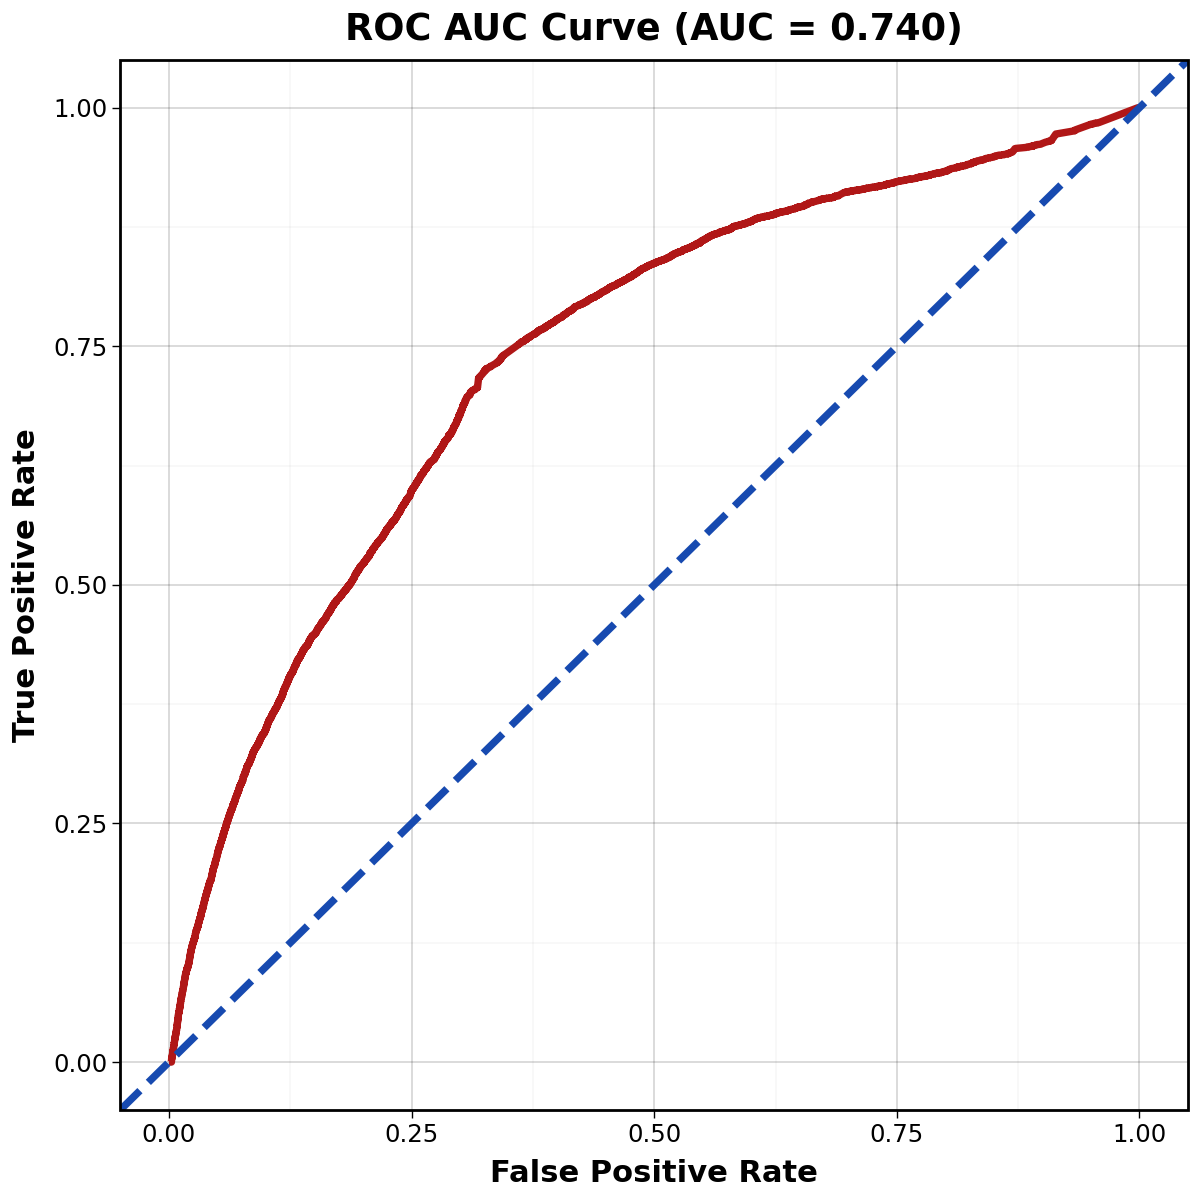

In [70]:
#  Curva ROC
auc_curve_isof = plot_roc_curve(y_test, y_probs_test)
auc_curve_isof.show()

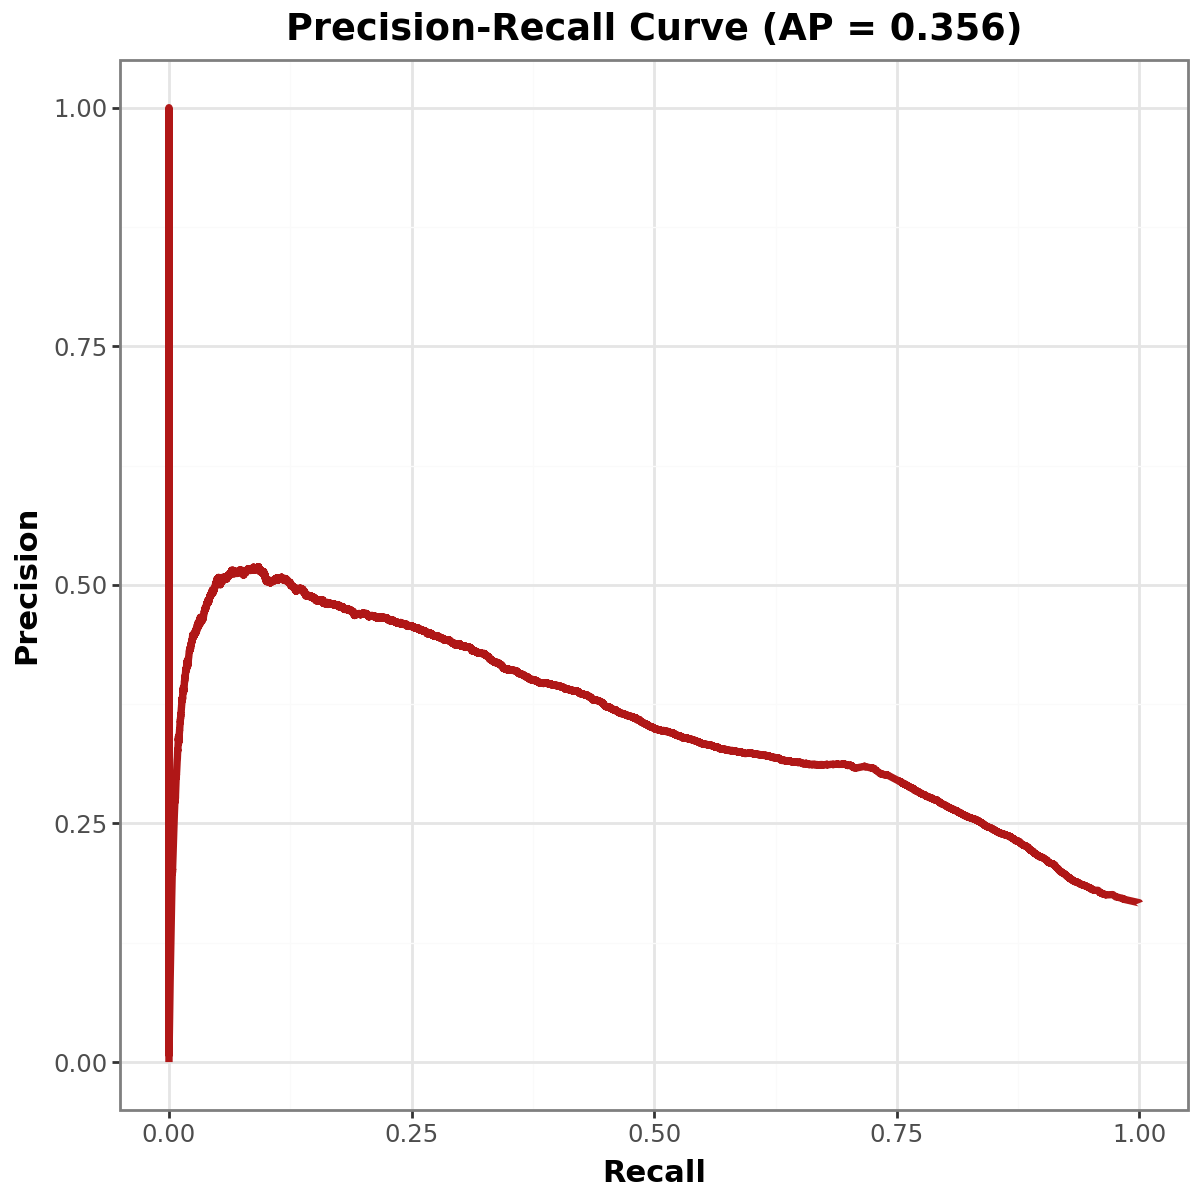

In [71]:
#Precision Recall Curve
precision_recall_graph = plot_precision_recall_curve(y_test, y_probs_test)
precision_recall_graph.show()

## Árbol de detección de fraude

Ahora vamos a comprobar si un método supervisado sencillo e interpretable, como es un árbol de decisión, puede ayudarnos a resolver este problema.

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
    Entrena un árbol de decisión sobre los datos de train, haciendo uso tanto de las variables explicativas como de la variable objetivo. Trata de que el árbol sea sencillo, de forma que puedas generar una visualización interpretable del mismo. Mide también los resultados del árbol en AUC sobre el conjunto de test. ¿Obtienes mejoras sobre el modelo no supervisado?
</font>

***

In [75]:
# Entrenando árbol de decisión
dtree = DecisionTreeClassifier(
    criterion='entropy',            # Función de división 
    max_depth=3,                    # Profundidad máxima del árbol
    min_samples_split=4,            # Número mínimo de muestras necesarias para dividir un nodo
    min_samples_leaf=10,            # Número mínimo de muestras en un nodo hoja
    class_weight={0.0: 1, 1.0: 4},  # Peso asisgnado a cada clase
    random_state=21                 # Semilla
)

dtree.fit(X_train, y_train)

# Predicción de la clase positiva 
y_probs_test = dtree.predict_proba(X_test)[:, 1]
y_probs_train = dtree.predict_proba(X_train)[:, 1]

# Calculando auc-score train
auc_score_train = roc_auc_score(y_train, y_probs_train)
print(f'Roc-auc score en train: {auc_score_train:.4}')

# Calculando auc-score test
auc_score_test = roc_auc_score(y_test, y_probs_test)
auc_models_test['Decision Tree'] = auc_score_test
print(f'Roc-auc score en test: {auc_score_test:.4}')

Roc-auc score en train: 0.7852
Roc-auc score en test: 0.7843


Se obtiene que el mejor model Decision Tree responde a las sigueintes consideraciones sobre el contexto de uso:
* Se aplica la entropia como criterio de ranmificación, ya que es óptimo en separar clases desproporcionadas como se da en este contexto de transaccioens fraudulentas.
* Se define una parametrización simplificada para asegurar la explicabilidad del modelo y asegurar que no se sobreajuste

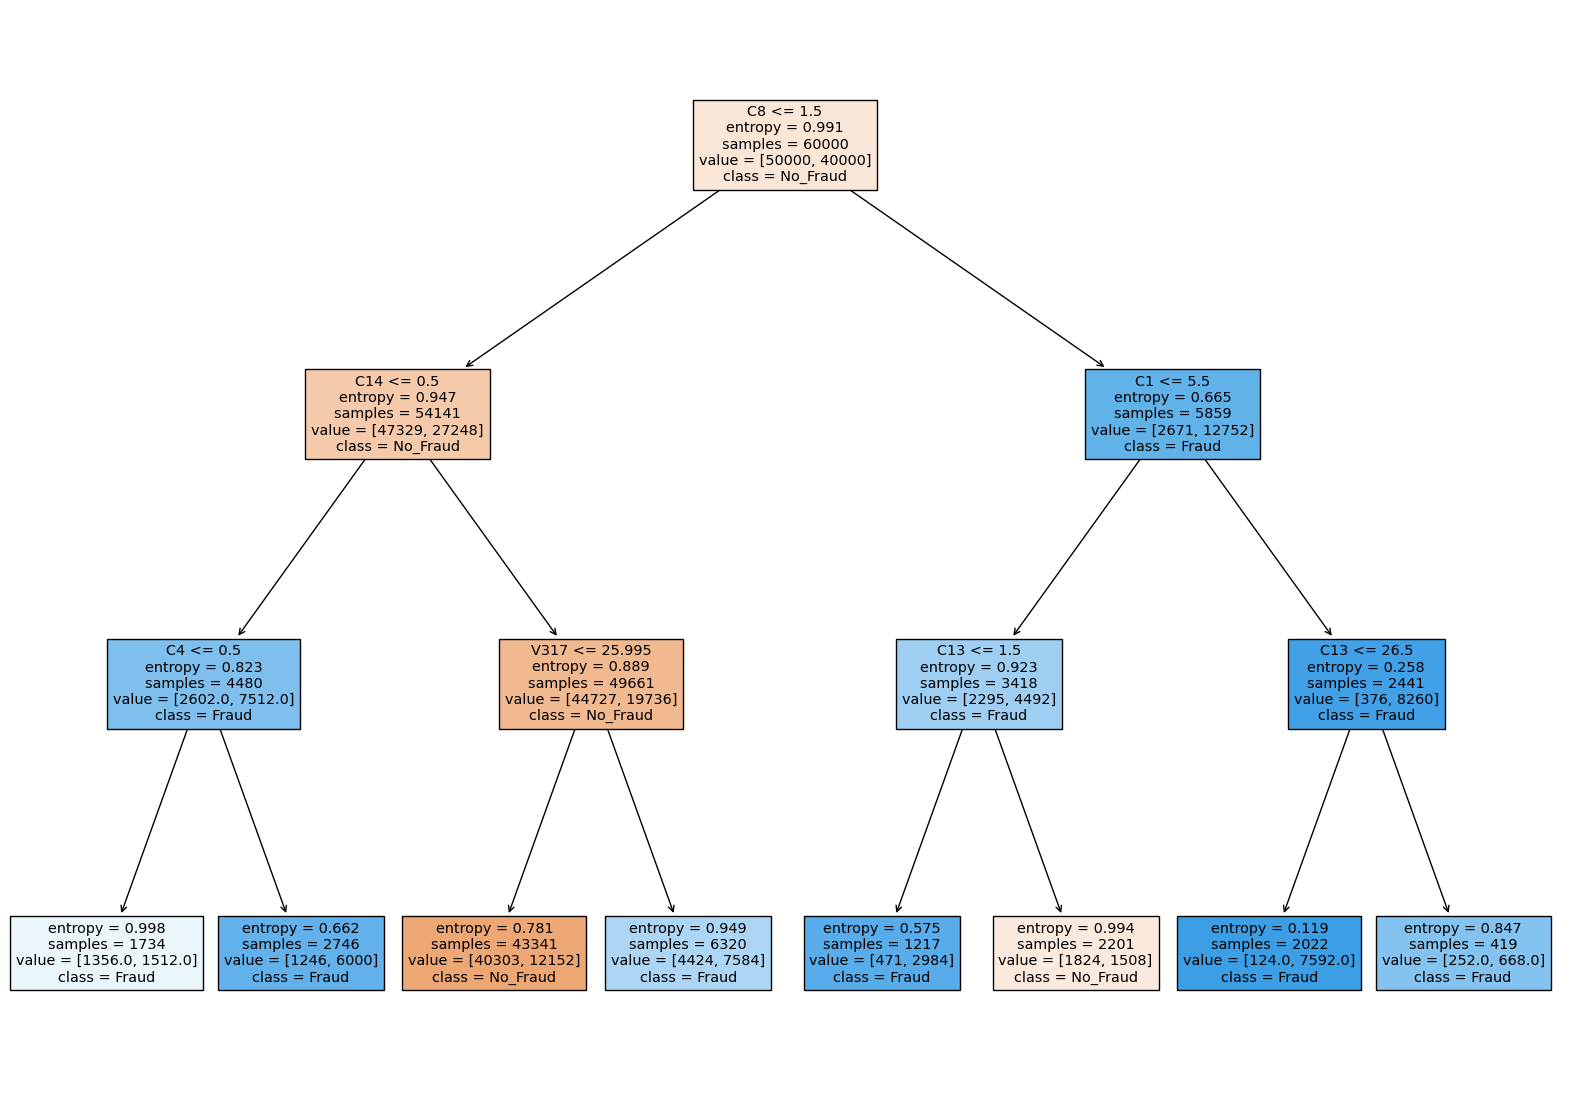

In [77]:
# Visualizando el árbol de decisión
plt.figure(figsize=(20, 14))
plot_tree(
    dtree,  # The tree we want to plot
    feature_names=X_train.columns,  # Take the feature names from the column names in the data
    class_names=["No_Fraud", "Fraud"],  # 0="Negative", 1="Positive"
    filled=True
)
plt.show()

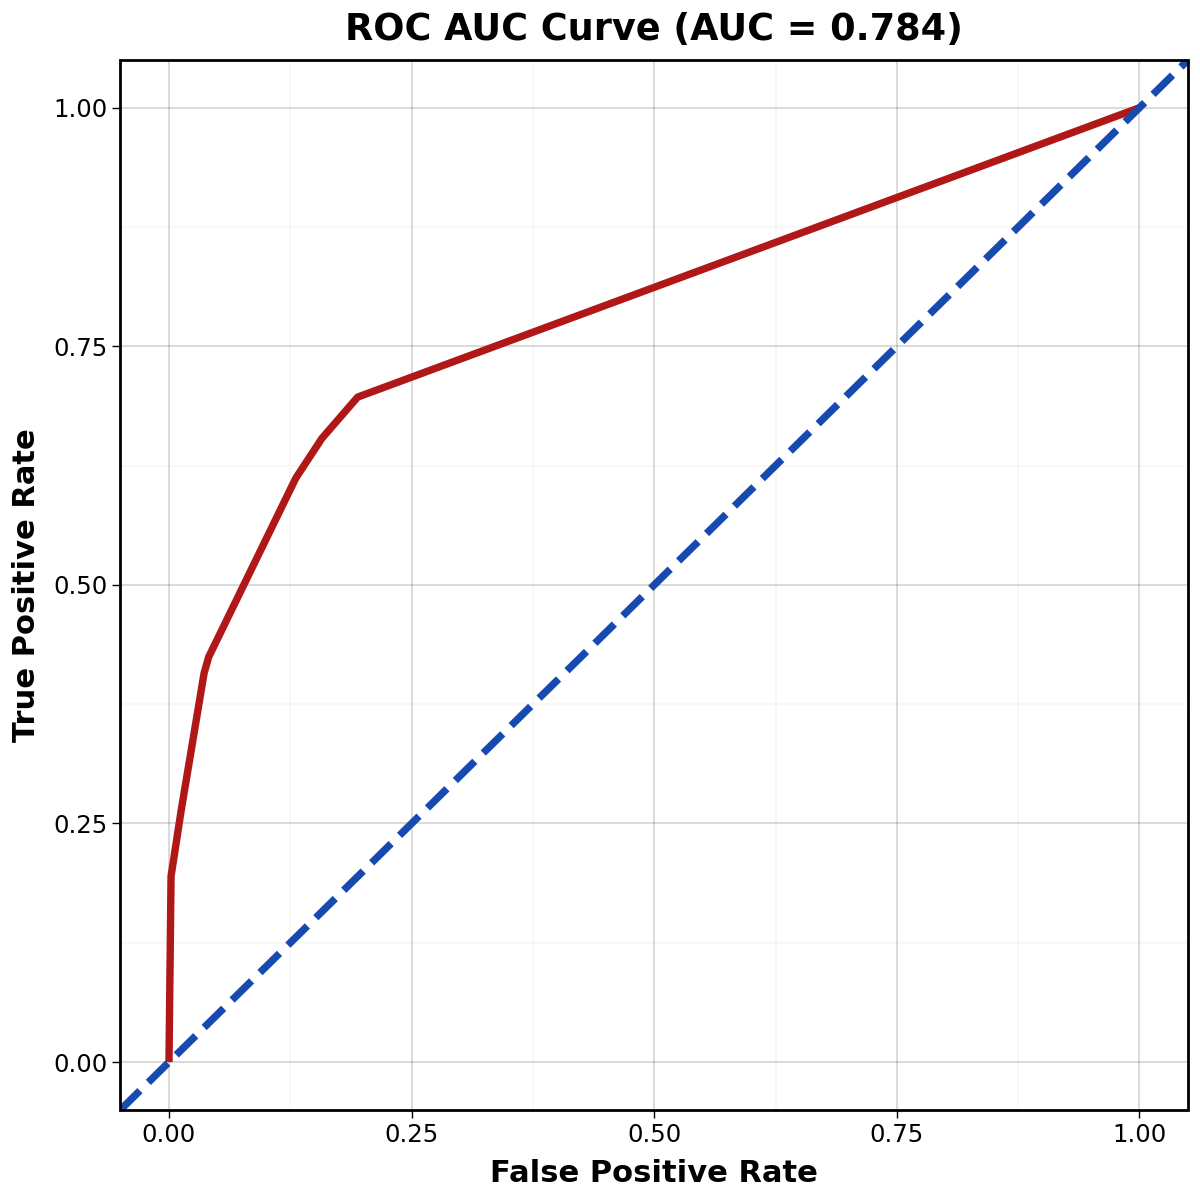

In [78]:
#  Curva ROC
auc_curve_dt = plot_roc_curve(y_test, y_probs_test)
auc_curve_dt.show()

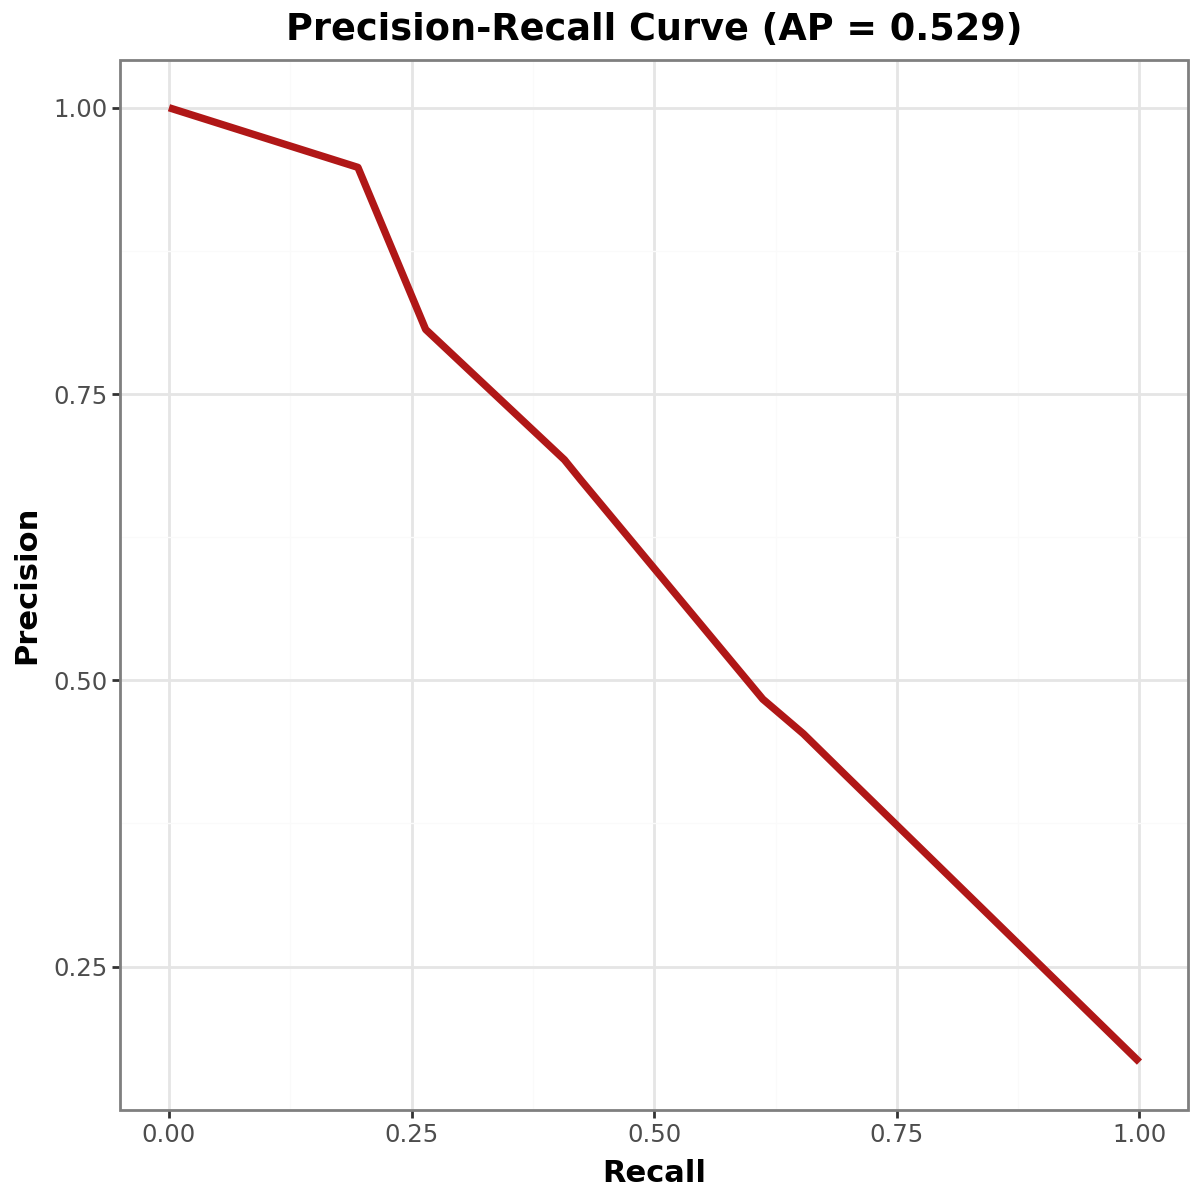

In [79]:
#Precision Recall Curve
precision_recall_graph = plot_precision_recall_curve(y_test, y_probs_test)
precision_recall_graph.show()

## Modelos supervisados de ensemble

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
    Vamos a comprobar cómo es posible mejorar los resultados de detección usando métodos de ensemble. Entrena <b>al menos 5 de los métodos de ensemble vistos en clase</b>, y mide sus resultados de AUC en el test.
</font>

***

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/exclamation.png" height="80" width="80" style="float: right;"/>

***
<font color=#2655ad>
Algunas sugerencias de modelos disponibles en scikit-learn que puedes utilizar:
    <ul>
        <li>Random Forest</li>
        <li>Extra Trees</li>
        <li>AdaBoost</li>
        <li>Gradient Boosting</li>
        <li>Histogram-based Gradient Boosting</li>
        <li>Bagging</li>
        <li>Voting</li>
        <li>Stacking</li>
    </ul>
No olvides que para medir correctamente el AUC, debes suministrar a esta métrica las <b>probabilidades de clase fraude</b> predichas por el modelo, las cuales puedes obtener mediante el método <i>predict_proba</i>.
    
Si has entrenado los modelos correctamente, tu mejor resultado debería ser de al menos un <b>98% de AUC</b> en test.
</font>

***

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/pro.png" height="80" width="80" style="float: right;"/>

***
<font color=#259b4c>
Adicionalmente, se valorará:
    <ul>
        <li>Utilizar más técnicas de ensembles, además de las 5 mínimas requeridas.</li>
        <li>Mejorar el AUC en test de tu modelo lo máximo posible.</li>
        <li>Utilizar <a href=https://catboost.ai/>CatBoost</a>, <a href=https://lightgbm.readthedocs.io/en/latest/>LightGBM</a> o <a href=https://auto.gluon.ai/>AutoGluon</a>, otras librerías de ensemble muy efectivas. Nótese que deberás instalar estas librerías en el entorno.</li>
    </ul>
</font>

***

In [84]:
# Random Forest
# Parametrización del modelo
rf_model = RandomForestClassifier(
    n_estimators=110,                     # Número de árboles en el modelo
    max_depth=10,                         # Profundidad máxima de cada árbol (controla el sobreajuste)
    max_features=None,                    # Utilizar todas las características para la división de cada árbol
    min_samples_split=5,                  # Número mínimo de muestras requeridas para dividir un nodo
    min_samples_leaf=4,                   # Número mínimo de muestras en un nodo hoja
    class_weight='balanced_subsample',    # Ponderación de clases para manejar desbalance de clases
    bootstrap=True,                       # Utilizar muestreo con reemplazo (Bootstrap)
    random_state=21,                      # Semilla 
    n_jobs=-1                             # Usar todos los núcleos de CPU disponibles 
)

# Entrenamiento del modelo
rf_model.fit(X_train, y_train)

# Predicción de la clase positiva 
y_probs_test = rf_model.predict_proba(X_test)[:, 1]
y_probs_train = rf_model.predict_proba(X_train)[:, 1]

# Calculando auc-score train
auc_score_train = roc_auc_score(y_train, y_probs_train)
print(f'Roc-auc score en train: {auc_score_train:.4}')

# Calculando auc-score test
auc_score_test = roc_auc_score(y_test, y_probs_test)
auc_models_test['Random Forest'] = auc_score_test
print(f'Roc-auc score en test: {auc_score_test:.4}')

KeyboardInterrupt: 

In [ ]:
# DataFrame con la importancia de las varaibles
importance_df = pd.DataFrame({'Feature': X_train.columns ,'Importance': rf_model.feature_importances_})

# Selección de las n variables más importantes
importance_df_top = importance_df.nlargest(10, 'Importance')

# Orden de las varaibles por importancia
importance_df_filtered = importance_df_top.sort_values(by='Importance', ascending=False)

# Gráfico
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df_filtered)
plt.title('Importancia de los top 10 predictores')
plt.show()

Se obtiene que el mejor modelo de Random Forest responde a las siguientes consideraciones sobre el contexto de uso:

* Se emplean 110 árboles en el modelo para asegurar diversidad y robustez en la clasificación, minimizando el riesgo de sobreajuste.
* La profundidad máxima de 10 sugiere que usar más profundidad que la usada en el Decision Tree, se logra mejorar el modelo sin caer en el overfitting, aunque empieza a dificultar su explicabilidad.

In [ ]:
#  Curva ROC
auc_curve_dt = plot_roc_curve(y_test, y_probs_test)
auc_curve_dt.show()

In [ ]:
#Precision Recall Curve
precision_recall_graph = plot_precision_recall_curve(y_test, y_probs_test)
precision_recall_graph.show()

In [ ]:
# AdaBoost
# Creación del estimador base 
base_estimator = RandomForestClassifier(
    n_estimators=100,                     # Número de árboles en el modelo
    max_depth=5,                         # Profundidad máxima de cada árbol (controla el sobreajuste)
    min_samples_split=5,                  # Número mínimo de muestras requeridas para dividir un nodo
    min_samples_leaf=4,                   # Número mínimo de muestras en un nodo hoja
    class_weight='balanced_subsample',    # Ponderación de clases para manejar desbalance de clases
    random_state=21,                      # Semilla 
    n_jobs=-1                             # Usar todos los núcleos de CPU disponibles 
)


# Parametrización del modelo
ada_model = AdaBoostClassifier(
    estimator=base_estimator,   # Estimador base -> RandomForestClassifier
    n_estimators=75,           # Número de árboles en el modelo
    learning_rate=0.6300,       # Tasa de aprendizaje
    random_state=21             # Semilla
)

# Entrenamiento del modelo
ada_model.fit(X_train, y_train)

# Predicción de la clase positiva 
y_probs_test = ada_model.predict_proba(X_test)[:, 1]
y_probs_train = ada_model.predict_proba(X_train)[:, 1]

# Calculando auc-score train
auc_score_train = roc_auc_score(y_train, y_probs_train)
print(f'Roc-auc score en train: {auc_score_train:.4}')

# Calculando auc-score test
auc_score_test = roc_auc_score(y_test, y_probs_test)
auc_models_test['AdaBoost'] = auc_score_test
print(f'Roc-auc score en test: {auc_score_test:.4}')

El modelo de AdaBoost se planteo en usar el modelo supervisado anterior Random Forest con el propósito de mejorarlo, pero con una parametrización simplificada para evitar el overfitting. De igual modo, dado que se parte de un modelo que anteriormente ya arrojó buenos resultados, se aplica una tasa de aprendizaje no muy alta.

In [ ]:
#  Curva ROC
auc_curve_dt = plot_roc_curve(y_test, y_probs_test)
auc_curve_dt.show()

In [ ]:
#Precision Recall Curve
precision_recall_graph = plot_precision_recall_curve(y_test, y_probs_test)
precision_recall_graph.show()

In [ ]:
# Gradient Boosting
# Parametrización del modelo
gb_model = GradientBoostingClassifier(
    n_estimators=150,               # Número de árboles en el modelo 
    learning_rate=0.105,            # Tasa de aprendizaje 
    subsample=0.700,                # Proporción de muestras utilizadas para entrenar cada árbol
    max_depth=8,                    # Profundidad máxima de los árboles 
    min_samples_split=8,            # Número mínimo de muestras necesarias para dividir un nodo interno
    min_samples_leaf=5,             # Número mínimo de muestras en un nodo hoja 
    random_state=21                 # Semilla 
)


# Entrenamiento del modelo
gb_model.fit(X_train, y_train)

# Predicción de la clase positiva 
y_probs_test = gb_model.predict_proba(X_test)[:, 1]
y_probs_train = gb_model.predict_proba(X_train)[:, 1]

# Calculando auc-score train
auc_score_train = roc_auc_score(y_train, y_probs_train)
print(f'Roc-auc score en train: {auc_score_train:.4}')

# Calculando auc-score test
auc_score_test = roc_auc_score(y_test, y_probs_test)
auc_models_test['Gradient Boosting'] = auc_score_test
print(f'Roc-auc score en test: {auc_score_test:.4}')

In [ ]:
#  Curva ROC
auc_curve_dt = plot_roc_curve(y_test, y_probs_test)
auc_curve_dt.show()

In [ ]:
#Precision Recall Curve
precision_recall_graph = plot_precision_recall_curve(y_test, y_probs_test)
precision_recall_graph.show()

In [ ]:
# Extreme Gradient Boosting
# Parametrización del modelo
xgb_model = XGBClassifier( 
    n_estimators=200,                   # Número de árboles en el modelo 
    learning_rate=0.1695,               # Tasa de aprendizaje 
    max_depth=10,                       # Profundidad máxima de los árboles 
    min_child_weight=1,                 # Peso mínimo de las observaciones en un nodo hoja para hacer una partición
    subsample=0.9640,                   # Proporción de muestras utilizadas para entrenar cada árbol 
    colsample_bytree=0.8510,            # Proporción de características utilizadas para entrenar cada árbol
    gamma=0.2670,                       # Penalización de la complejidad del modelo
    reg_lambda=4.001,                   # Regularización L2 para evitar el sobreajuste 
    random_state=21,                    # Semilla 
    tree_method='hist',                 # Método de construcción de árboles optimizado para uso de GPU
    device='cuda',                      # Especifica el uso de GPU para acelerar el entrenamiento
    n_jobs=-1                           # Uso de todos los núcleos de CPU disponibles para acelerar el proceso
)


# Entrenamiento del modelo
xgb_model.fit(X_train, y_train)

# Predicción de la clase positiva 
y_probs_test = xgb_model.predict_proba(X_test)[:, 1]
y_probs_train = xgb_model.predict_proba(X_train)[:, 1]

# Calculando auc-score train
auc_score_train = roc_auc_score(y_train, y_probs_train)
print(f'Roc-auc score en train: {auc_score_train:.4}')

# Calculando auc-score test
auc_score_test = roc_auc_score(y_test, y_probs_test)
auc_models_test['XGBoost'] = auc_score_test
print(f'Roc-auc score en test: {auc_score_test:.4}')

In [ ]:
#  Curva ROC
auc_curve_dt = plot_roc_curve(y_test, y_probs_test)
auc_curve_dt.show()

In [ ]:
# Precision Recall Curve
precision_recall_graph = plot_precision_recall_curve(y_test, y_probs_test)
precision_recall_graph.show()

In [ ]:
# Histogram Gradient Boosting
# Parametrización del modelo
hist_gb_model = HistGradientBoostingClassifier(
    max_iter=200,                     # Número máximo de iteraciones
    learning_rate=0.2960,             # Tasa de aprendizaje 
    max_depth=9,                      # Profundidad máxima de los árboles 
    min_samples_leaf=3,               # Número mínimo de muestras requeridas en un nodo hoja 
    max_bins=220,                     # Número máximo de compartimientos
    l2_regularization=1.330,          # Regularización L2 para evitar el sobreajuste
    random_state=21                   # Semilla 
)

# Entrenamiento del modelo
hist_gb_model.fit(X_train, y_train)

# Predicción de la clase positiva 
y_probs_test = hist_gb_model.predict_proba(X_test)[:, 1]
y_probs_train = hist_gb_model.predict_proba(X_train)[:, 1]

# Calculando auc-score train
auc_score_train = roc_auc_score(y_train, y_probs_train)
print(f'Roc-auc score en train: {auc_score_train:.4}')

# Calculando auc-score test
auc_score_test = roc_auc_score(y_test, y_probs_test)
auc_models_test['HistGradientBoosting'] = auc_score_test
print(f'Roc-auc score en test: {auc_score_test:.4}')

In [ ]:
#  Curva ROC
auc_curve_dt = plot_roc_curve(y_test, y_probs_test)
auc_curve_dt.show()

In [ ]:
# Precision Recall Curve
precision_recall_graph = plot_precision_recall_curve(y_test, y_probs_test)
precision_recall_graph.show()

In [ ]:
# CatBoosting
# Parametrización del modelo
cb_model = CatBoostClassifier(
    iterations=980,                   # Número de árboles 
    learning_rate=0.0733,             # Tasa de aprendizaje 
    depth=9,                          # Profundidad máxima de los árboles 
    model_size_reg=0.610,             # Regularización en el tamaño del modelo 
    min_data_in_leaf=1,               # Número mínimo de muestras en un nodo hoja 
    bagging_temperature=0.0005,       # Control del grado de aleatorización en el muestreo 
    random_strength=0.130,            # Control de la aleatorización de la selección de características para cada árbol
    reg_lambda=6.1465,                # Regularización L2 
    max_bin=170,                      # Número máximo de compartimientos
    task_type="GPU",                  # Uso de GPU para acelerar el entrenamiento
    random_state=21,                  # Semilla
    silent=True                       # Verbose apagado
)


# Entrenamiento del modelo
cb_model.fit(X_train, y_train)

# Predicción de la clase positiva 
y_probs_test = cb_model.predict_proba(X_test)[:, 1]
y_probs_train = cb_model.predict_proba(X_train)[:, 1]

# Calculando auc-score train
auc_score_train = roc_auc_score(y_train, y_probs_train)
print(f'Roc-auc score en train: {auc_score_train:.4}')

# Calculando auc-score test
auc_score_test = roc_auc_score(y_test, y_probs_test)
auc_models_test['CatBoost'] = auc_score_test
print(f'Roc-auc score en test: {auc_score_test:.4}')

In [ ]:
#  Curva ROC
auc_curve_dt = plot_roc_curve(y_test, y_probs_test)
auc_curve_dt.show()

In [ ]:
# Precision Recall Curve
precision_recall_graph = plot_precision_recall_curve(y_test, y_probs_test)
precision_recall_graph.show()

In [ ]:
# Light Gradient Boosting
# Parametrización del modelo
lgbm_model = LGBMClassifier(
    num_leaves=100,                   # Número máximo de hojas por árbol 
    learning_rate=0.0640,             # Tasa de aprendizaje 
    n_estimators=655,                 # Número de árboles en el modelo 
    max_depth=9,                      # Profundidad máxima de cada árbol 
    min_child_samples=23,             # Número mínimo de muestras necesarias para crear un nodo hijo 
    subsample=0.66,                 # Proporción de muestras utilizadas para entrenar cada árbol 
    colsample_bytree=0.6525,          # Proporción de características utilizadas para entrenar cada árbol
    reg_alpha=0.5431,                 # Regularización L1 
    reg_lambda=0.3348,                # Regularización L2 
    scale_pos_weight=1.1880,          # Peso ajustado para las clases desbalanceadas
    random_state=21,                  # Semilla 
    n_jobs=-1,                        # Uso todos los núcleos de CPU disponibles
    verbose=-1                        # Verbose apagado
)


# Entrenamiento del modelo
lgbm_model.fit(X_train, y_train)

# Predicción de la clase positiva 
y_probs_test = lgbm_model.predict_proba(X_test)[:, 1]
y_probs_train = lgbm_model.predict_proba(X_train)[:, 1]

# Calculando auc-score train
auc_score_train = roc_auc_score(y_train, y_probs_train)
print(f'Roc-auc score en train: {auc_score_train:.4}')

# Calculando auc-score test
auc_score_test = roc_auc_score(y_test, y_probs_test)
auc_models_test['LightGBM'] = auc_score_test
print(f'Roc-auc score en test: {auc_score_test:.4}')

In [ ]:
#  Curva ROC
auc_curve_dt = plot_roc_curve(y_test, y_probs_test)
auc_curve_dt.show()

In [ ]:
#Precision Recall Curve
precision_recall_graph = plot_precision_recall_curve(y_test, y_probs_test)
precision_recall_graph.show()

In [ ]:
# Generación de una clase extendida del Isolation Forest con métodos usados en stacking y voting
class IsolationForestWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, isolation_forest):
        self.isolation_forest = isolation_forest

    def fit(self, X, y=None):
        # Entrena el modelo Isolation Forest
        self.isolation_forest.fit(X)
        # Calcula las puntuaciones en el conjunto de entrenamiento
        train_scores = -self.isolation_forest.score_samples(X)
        # Almacena los valores mínimo y máximo para la normalización
        self.min_score_ = train_scores.min()
        self.max_score_ = train_scores.max()
        # Define las clases en función del vector y, si se proporciona
        if y is not None:
            self.classes_ = np.unique(y)
        else:
            self.classes_ = np.array([0, 1])
        return self

    def predict_proba(self, X):
        # Puntuaciones de las muestras
        y_scores = -self.isolation_forest.score_samples(X)
        # Normalización [0, 1]
        scaled = (y_scores - self.min_score_) / (self.max_score_ - self.min_score_)
        # Corroborar limites [0, 1]
        scaled = np.clip(scaled, 0, 1)
        # Retorna dos columnas con las clases
        proba = np.column_stack([1 - scaled, scaled])
        return proba

    def predict(self, X):
        # Predecir clases usando 0.5 como umbral
        proba = self.predict_proba(X)
        return np.where(proba[:, 1] >= 0.5, 1, 0)


In [ ]:
# Se agregan métodos al Isolation Forest base con la función definida
if_wrapper = IsolationForestWrapper(isoforest_model)

# Se definen los modelos base 
models_base = [
    ('XGBoost', xgb_model),
    ('CatBoost', cb_model),
    ('LightGBM', lgbm_model),
    ('Random Forest', rf_model),
    ('Isolation Forest', if_wrapper)
]

# Se define el metamodelo de salida
meta_model = LogisticRegression(random_state=21, n_jobs=-1)

# Se crea el StackingClassifier con los modelos base
stacking_model = StackingClassifier(estimators=models_base, final_estimator=meta_model)

# Entranamiento del modelo
stacking_model.fit(X_train, y_train)

# Predicción de la clase positiva 
y_probs_train = stacking_model.predict(X_train)
y_probs_test = stacking_model.predict(X_test)

# Evaluar el rendimiento del modelo 
voting_acc_train = accuracy_score(y_train, y_probs_train)
voting_acc_test = accuracy_score(y_test, y_probs_test)
auc_models_test['Stacking'] = auc_score_test
print(f'Accuracy en train: {voting_acc_train:.4f}')
print(f'Accuracy en test: {voting_acc_test:.4f}')

In [ ]:
#  Curva ROC
auc_curve_dt = plot_roc_curve(y_test, y_probs_test)
auc_curve_dt.show()

In [ ]:
#Precision Recall Curve
precision_recall_graph = plot_precision_recall_curve(y_test, y_probs_test)
precision_recall_graph.show()

In [ ]:
# Se crea el VotingClassifier con los modelos base
voting_model = VotingClassifier(estimators=models_base, voting='soft')

# Entranamiento del modelo
voting_model.fit(X_train, y_train)

# Predicción de la clase positiva 
y_probs_train = voting_model.predict(X_train)
y_probs_test = voting_model.predict(X_test)

# Evaluar el rendimiento del modelo 
voting_acc_train = accuracy_score(y_train, y_probs_train)
voting_acc_test = accuracy_score(y_test, y_probs_test)
print(f'Accuracy en train: {voting_acc_train:.4f}')
auc_models_test['Voting'] = auc_score_test
print(f'Accuracy en test: {voting_acc_test:.4f}')

In [ ]:
#  Curva ROC
auc_curve_dt = plot_roc_curve(y_test, y_probs_test)
auc_curve_dt.show()

In [ ]:
#Precision Recall Curve
precision_recall_graph = plot_precision_recall_curve(y_test, y_probs_test)
precision_recall_graph.show()

## Visualización

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
    Crea una visualización mostrando el rendimiento de todos tus modelos supervisados sobre el conjunto de test, junto con el modelo no supervisado. La visualización debe mostrar claramente cuál es el modelo con mayor AUC.
</font>

***

In [ ]:
# Ordenar los modelos por AUC en un DataFrame
sorted_models = sorted(auc_models_test.items(), key=lambda x: x[1], reverse=False)
sorted_models_df = pd.DataFrame(sorted_models, columns=['Model', 'AUC'])

# Se categorizan los modelos (orden gráfico)
sorted_models_df['Model'] = pd.Categorical(sorted_models_df['Model'], categories=sorted_models_df['Model'], ordered=True)

# Gráfica comparativa de modelos
final_plot = (
    ggplot(sorted_models_df, aes(x='Model', y='AUC'))
        + geom_bar(stat='identity', fill='skyblue')
        + geom_text(aes(label=sorted_models_df['AUC'].apply(lambda x: f"{x:.3f}")), va='center', ha='right', color='black')
        + scale_y_continuous(limits=(0, 1))
        + labs(x='Modelo', y='AUC Score', title='Comparación de Modelos - AUC en Test')
        + theme_linedraw()
        + theme(
            figure_size=(10, 5),                        # Tamaño de la figura
            plot_title=element_text(weight='bold'),    # Título en negrita
            axis_title_x=element_text(weight='bold'),  # Título eje X en negrita
            axis_title_y=element_text(weight='bold')   # Título eje Y en negrita
        )
        + coord_flip()
       )
final_plot.show()